# Fit HAT-P-67 b and stellar variability with `exoplanet`

This notebook is based off the `exoplanet` case study:
> Simultaneous Fitting of a Transit with Stellar Variability

gully, March 2022

In [1]:
import exoplanet as xo

xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


exoplanet.__version__ = '0.5.3'


In [2]:
%config InlineBackend.figure_format='retina'

# Datasets and initializations

First, let's download the long cadence light curves from MAST using the `lightkurve` package.

In [3]:
%config Completer.use_jedi = False

In [4]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [5]:
sr = lk.search_lightcurve('HAT-P-67', author='SPOC')

In [6]:
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 24,2020,SPOC,120,198588220,0.0
1,TESS Sector 26,2020,SPOC,120,198588220,0.0
2,TESS Sector 51,2022,SPOC,120,198588220,0.0
3,TESS Sector 52,2022,SPOC,120,198588220,0.0
4,TESS Sector 53,2022,SPOC,120,198588220,0.0


We only want the two-minute cadence lightcurves.

In [7]:
#sr = lk.search_targetpixelfile('HAT-P-67', author='spoc')
#target_mask = tpf.create_threshold_mask(15, reference_pixel='center')
#back_mask = ~tpf.create_threshold_mask(0.1, reference_pixel=None)
#n_pix = target_mask.sum()
#lc_targ = tpf.extract_aperture_photometry(aperture_mask=target_mask, flux_method='sum')
#lc_back = tpf.extract_aperture_photometry(aperture_mask=back_mask, flux_method='mean')
#lc_net = lc_targ - lc_back*n_pix
#ax = lc_net.normalize().plot()
#lc_back.normalize().plot(ax=ax)

In [8]:
lcs = sr.download_all()
lc = lcs.stitch().normalize().remove_nans()

In [9]:
#lc = sr[4].download().normalize().remove_nans()

In [10]:
# Make sure that the data type is consistent
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))

In [11]:
# Normalize around zero for GP fitting.  Keep in units of relative flux, rather
# than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


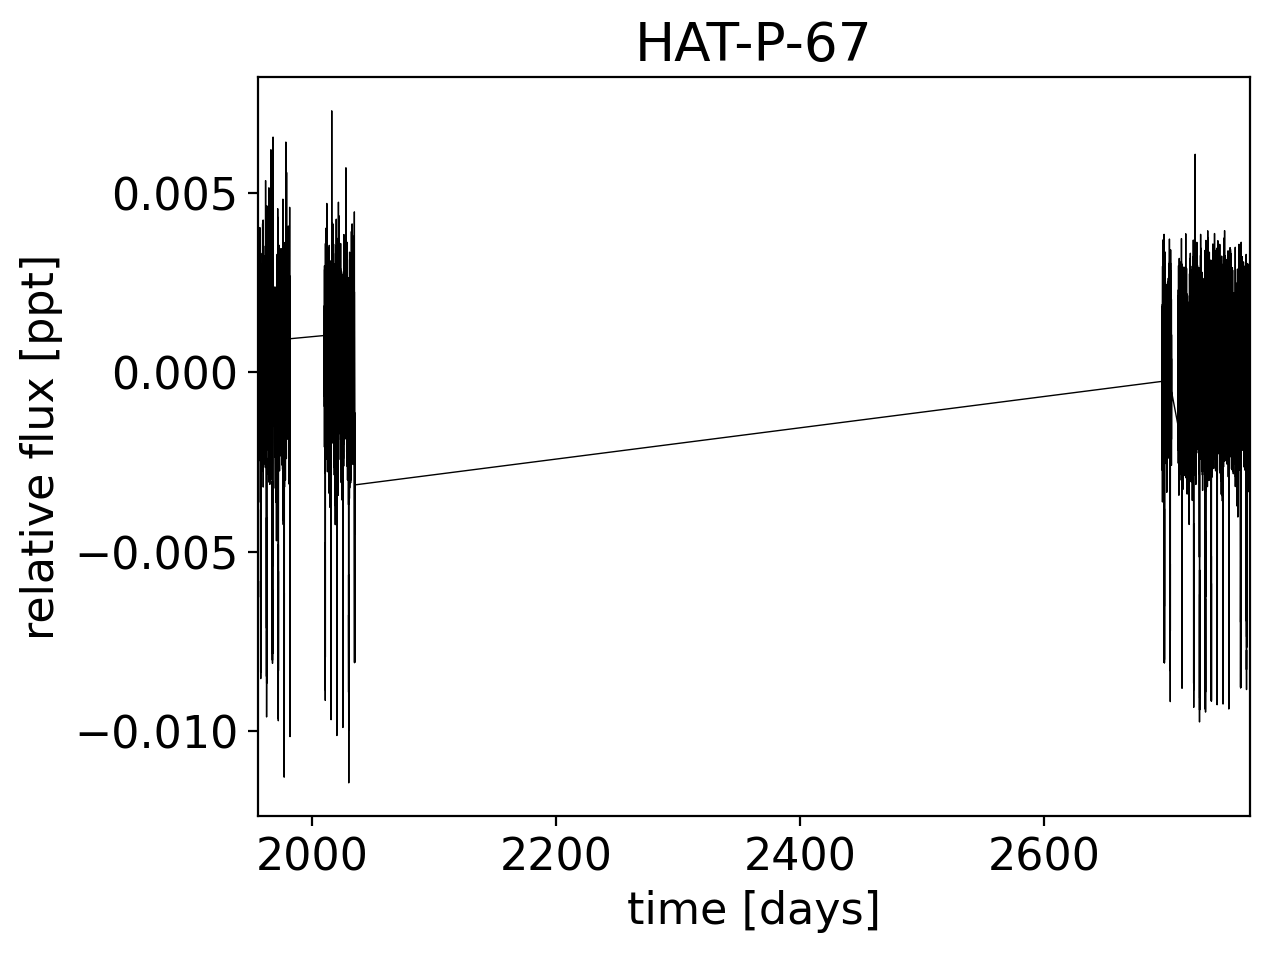

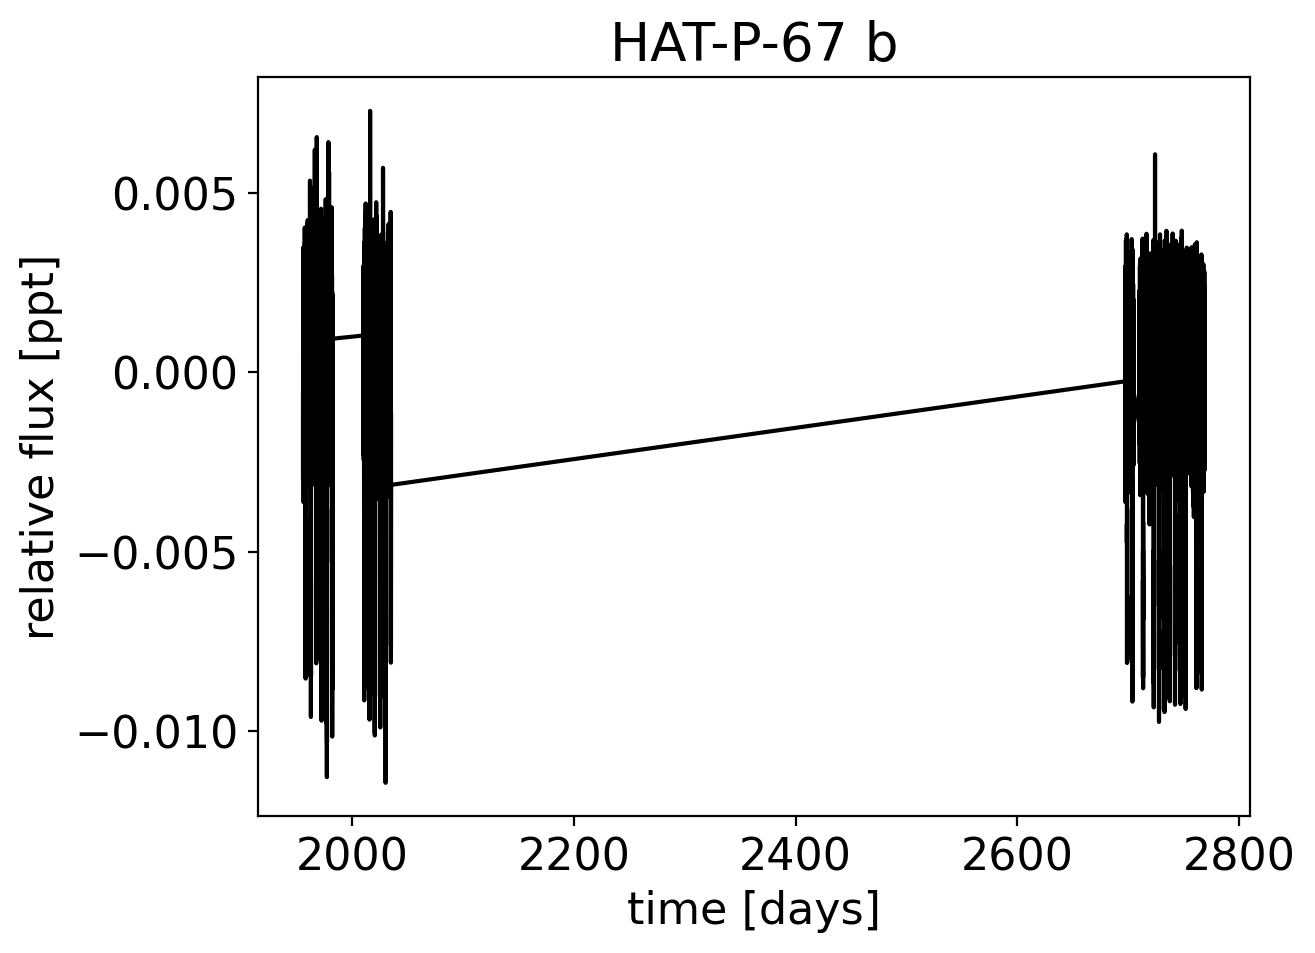

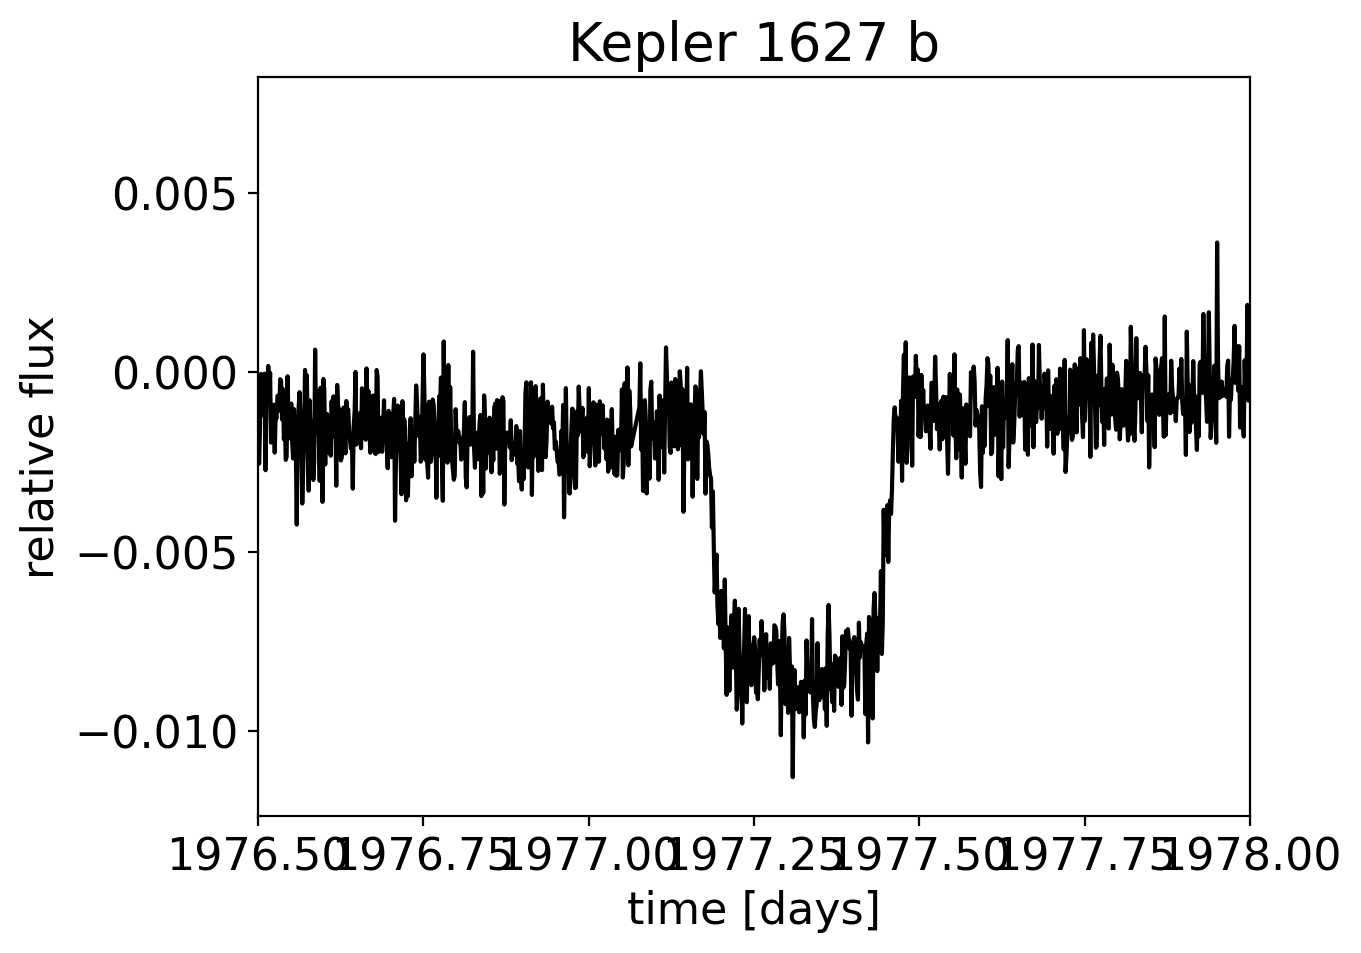

In [12]:
# Visualize the data.
# Plot #0: full dataset
# Plot #1: a 100 day slice
# Plot #2: center it on the known Kepler ephemeris.
plt.plot(x, y, "k", lw=0.5)
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HAT-P-67")
plt.show()

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
#plt.xlim([1970, 1980])
plt.title("HAT-P-67 b")
plt.show()

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([1976.5, 1978])  # transit is here
#plt.ylim([0, 5e-3])
plt.title("Kepler 1627 b")
plt.show()

Let's build a model that accounts for the spot-induced signal through a GP, and the transit signal separately.

In [13]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

from astropy import units as units, constants as const

In [14]:
T0_BTJD = 2458958.08059 - 2457000 #NASA Exoplanet Archive

In [15]:
def build_model(mask=None, start=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    with pm.Model() as model:

        # Shared parameters
        mean = pm.Normal("mean", mu=0, sd=1, testval=0)

        # Stellar parameters.  These are usually determined from spectroscopy
        # and/or isochrone fits.
        logg_star = pm.Normal("logg_star", mu=3.854, sd=0.002)
        r_star = pm.Normal("r_star", mu=2.546, sd=0.1)

        # Here "factor" is defined s.t. factor * 10**logg / r_star = rho
        factor = 5.141596357654149e-05
        rho_star = pm.Deterministic(
            "rho_star", factor * 10**logg_star / r_star
        )

        # Limb-darkening: adopt Kipping 2013.
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # To get Rp/R*, fit for log(depth).  This requires an impact parameter
        # prior from 0 to 1, because otherwise there's a sqrt(1-b^2) in the
        # conversion that doesn't make sense.  See
        # https://github.com/exoplanet-dev/exoplanet/blob/e99d1bd68654f21efbbf8400a83889a470d2baf7/src/exoplanet/light_curves/limb_dark.py#L73

        b = pm.Uniform("b", lower=0, upper=1)

        log_depth = pm.Normal("log_depth", mu=np.log(0.007), sigma=1)
        depth = pm.Deterministic("depth", tt.exp(log_depth))

        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(depth, b),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        # Orbital parameters for the planet.  Use mean values from Holczer+16.
        t0_BTJD = T0_BTJD
        t0 = pm.Normal("t0", mu=t0_BTJD, sd=0.02, testval=t0_BTJD)
        period = pm.Normal("period", mu=4.8101046, sd=0.01, testval=4.8101046)

        # Let the eccentricity float, and use the eccentricity distribution
        # from https://arxiv.org/abs/1807.00549 as our prior.
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=False, shape=1, fixed=True, observed=ecc
        )
        # Alternative choice:
        # xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Define the orbit model.
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            b=b,
            rho_star=rho_star,
            r_star=r_star,
            ecc=ecc,
            omega=omega,
        )

        transit_model = mean + tt.sum(
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
            axis=-1,
        )

        # Convenience function for plotting.
        pm.Deterministic(
            "transit_pred",
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
        )

        # Use the GP model from the stellar variability tutorial at
        # https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sd=2)

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5)
        )
        # Rotation period is about 4.9 days
        log_prot = pm.Normal("log_prot", mu=np.log(5.27), sd=0.3)
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)

        # Set up the Gaussian Process model. See
        # https://celerite2.readthedocs.io/en/latest/tutorials/first/ for an
        # introduction. Here, we have a quasiperiodic term:
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        #
        # Note mean of the GP is defined here to be zero, so our "observations"
        # will need to subtract the transit model.  The inverse choice could
        # also be made.
        #
        gp = GaussianProcess(
            kernel,
            t=x[mask],
            diag=yerr[mask] ** 2 + tt.exp(2 * log_jitter),
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("transit_obs", observed=y[mask] - transit_model)

        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(y[mask] - transit_model))

        # Track planet radius in Jovian radii
        r_planet = pm.Deterministic(
            "r_planet",
            (ror * r_star) * (1 * units.Rsun / (1 * units.Rjup)).cgs.value,
        )

        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                log_depth,
                b,
                ecc,
                omega,
                t0,
                period,
                r_star,
                logg_star,
                u_star,
                mean,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln

Initialize the model by optimizing.

In [16]:
model, map_estimate = build_model()

optimizing logp for variables: [log_dQ, log_Q0, log_prot, f, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: 411804.7964212178 -> 430095.1644959867
optimizing logp for variables: [mean, u_star, logg_star, r_star, period, t0, ecs, b, log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: 430095.16449598665 -> 432352.55044236954
optimizing logp for variables: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, ecs, period, t0, log_depth, b, u_star, r_star, logg_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 432352.55044236954 -> 442502.5388812061


Good! The log probability has increased at each step, which is typically what we want to see during optimization.
In the following cells, we'll define a plotting function that we can then use to visualize the model and the best-fit estimate.

In [17]:
import matplotlib as mpl

In [18]:
def plot_light_curve(x, y, soln, mask=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    ax = axes[0]

    if len(x[mask]) > int(2e4):
        # see https://github.com/matplotlib/matplotlib/issues/5907
        mpl.rcParams["agg.path.chunksize"] = 10000

    ax.scatter(
        x[mask],
        y[mask],
        c="k",
        s=0.5,
        rasterized=True,
        label="data",
        linewidths=0,
        zorder=42,
    )
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(
        x[mask], gp_mod, color="C2", label="MAP gp model", zorder=43, lw=2.5
    )
    ax.legend(fontsize=10)
    ax.set_ylabel("$f$")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(
            x[mask],
            mod,
            label="planet {0} [model under]".format(l),
            zorder=-10,
        )
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")

    ax = axes[2]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(x[mask], mod, label="planet {0} [model over]".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
    ymin = np.min(mod) - 0.05 * abs(np.min(mod))
    ymax = abs(ymin)
    ax.set_ylim([ymin, ymax])

    ax = axes[3]
    mod = gp_mod + np.sum(soln["transit_pred"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


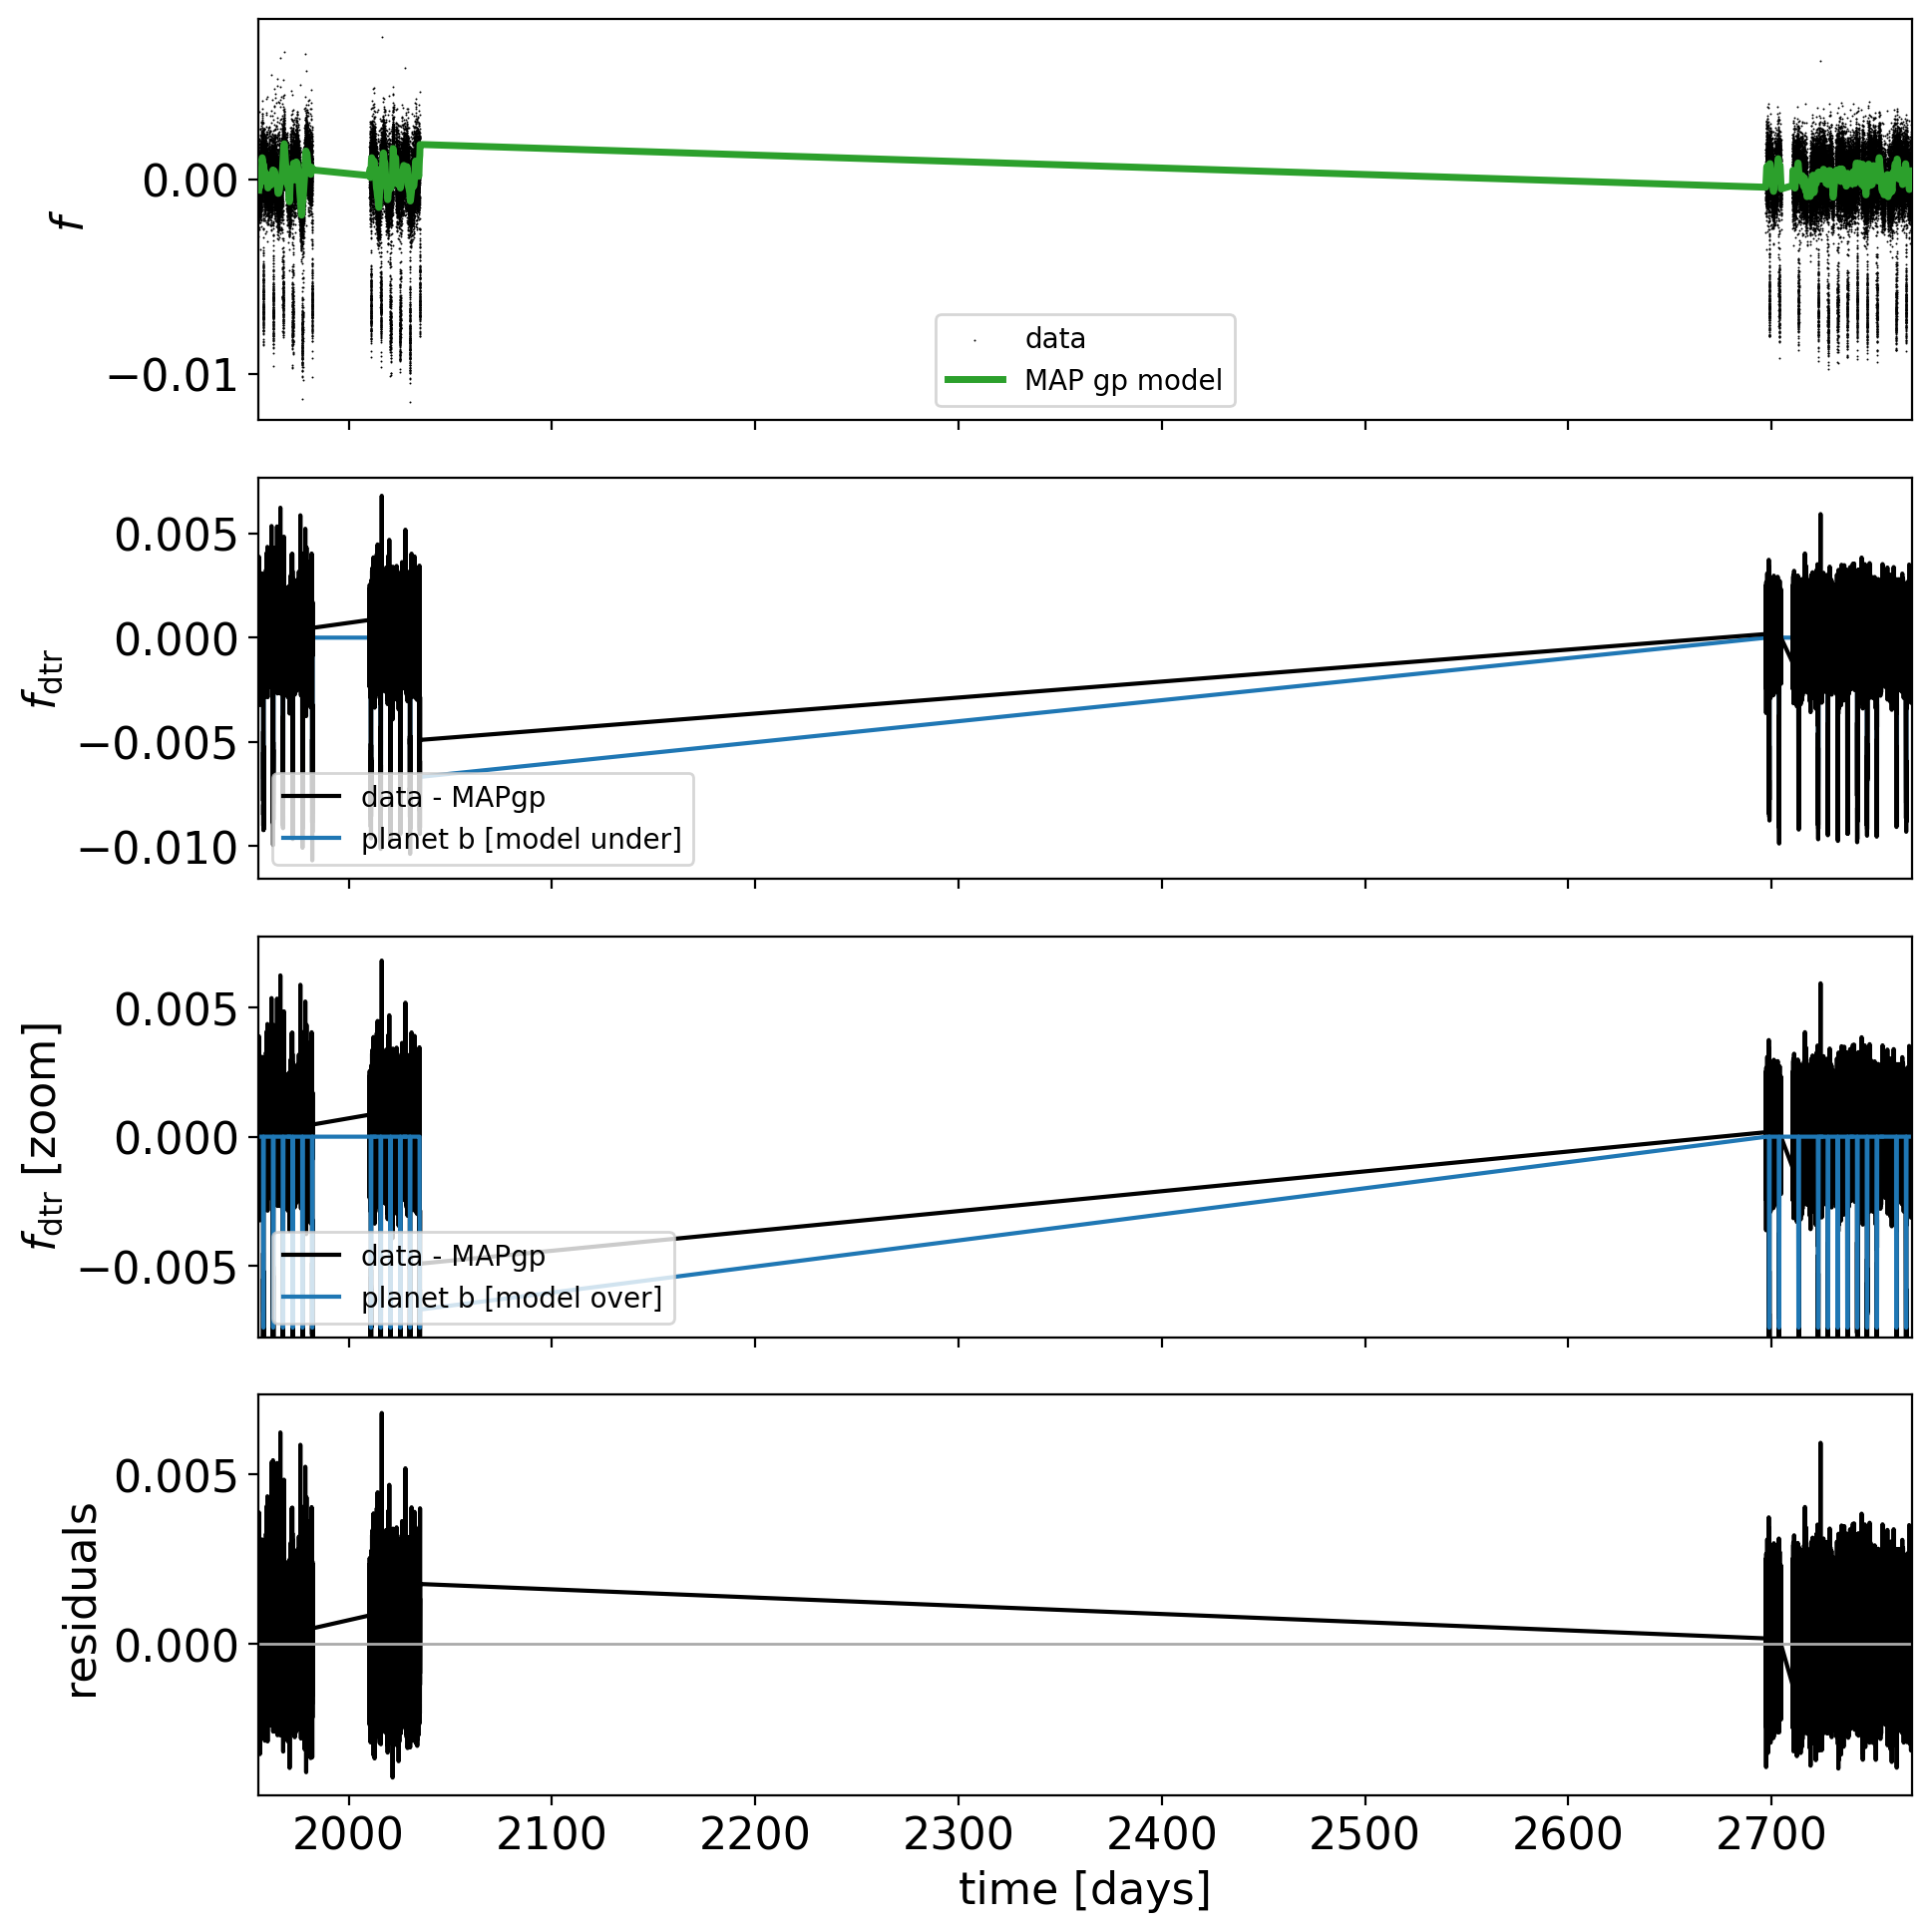

In [19]:
plot_light_curve(x, y, map_estimate)

Looks good!

In [20]:
soln = map_estimate

In [21]:
mod = soln["transit_pred"][:, 0]

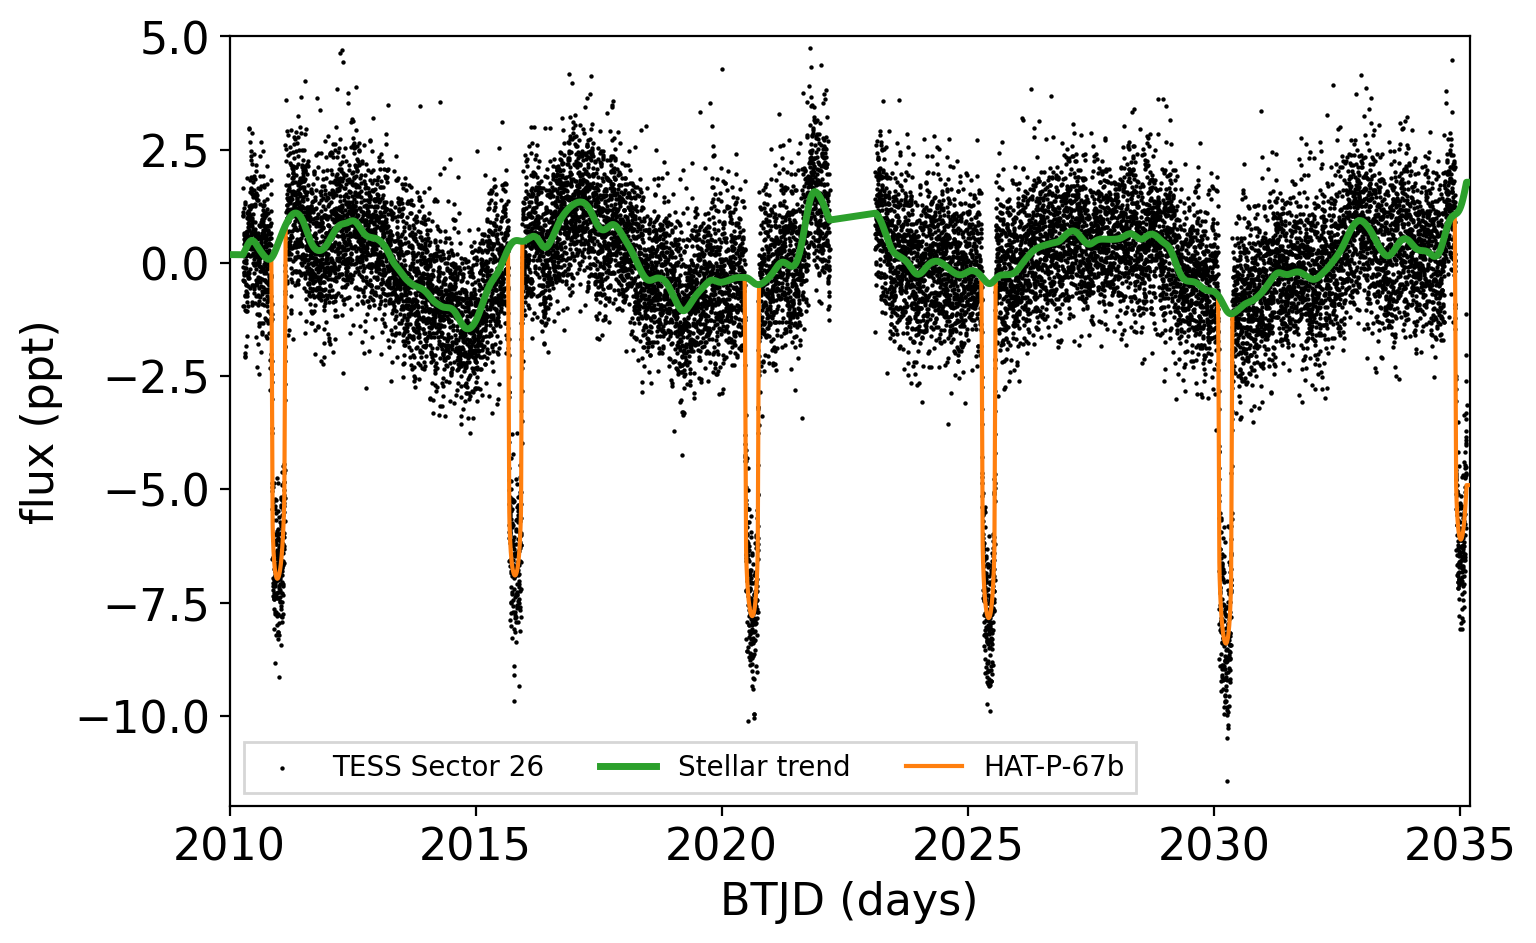

In [22]:
mask = np.ones(len(x), dtype=bool)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))


if len(x[mask]) > int(2e4):
    # see https://github.com/matplotlib/matplotlib/issues/5907
    mpl.rcParams["agg.path.chunksize"] = 10000

ax.scatter(
    x[mask],
    y[mask]*1000,
    c="k",
    s=2.5,
    rasterized=True,
    label="TESS Sector 26",
    linewidths=0,
    zorder=42,
)
gp_mod = (soln["gp_pred"] + soln["mean"])
gp_mod_plus = (soln["gp_pred"] + soln["mean"])+(soln["transit_pred"][:, 0])
ax.plot(
    x[mask], gp_mod*1000, color="C2", label="Stellar trend", zorder=43, lw=2.5
)
ax.plot(
    x[mask], gp_mod_plus*1000, color="C1", label="HAT-P-67b", zorder=42, lw=1.5
)
ax.legend(fontsize=10, ncol=3, facecolor='w', fancybox=False)
ax.set_ylabel("flux (ppt)")
ax.set_xlim(2010, 2035.2)
ax.set_ylim(-12, 5)
ax.set_xlabel("BTJD (days)")
plt.savefig('../../paper/paper1/figures/TESS_S26_trend.png', dpi=300, bbox_inches='tight')

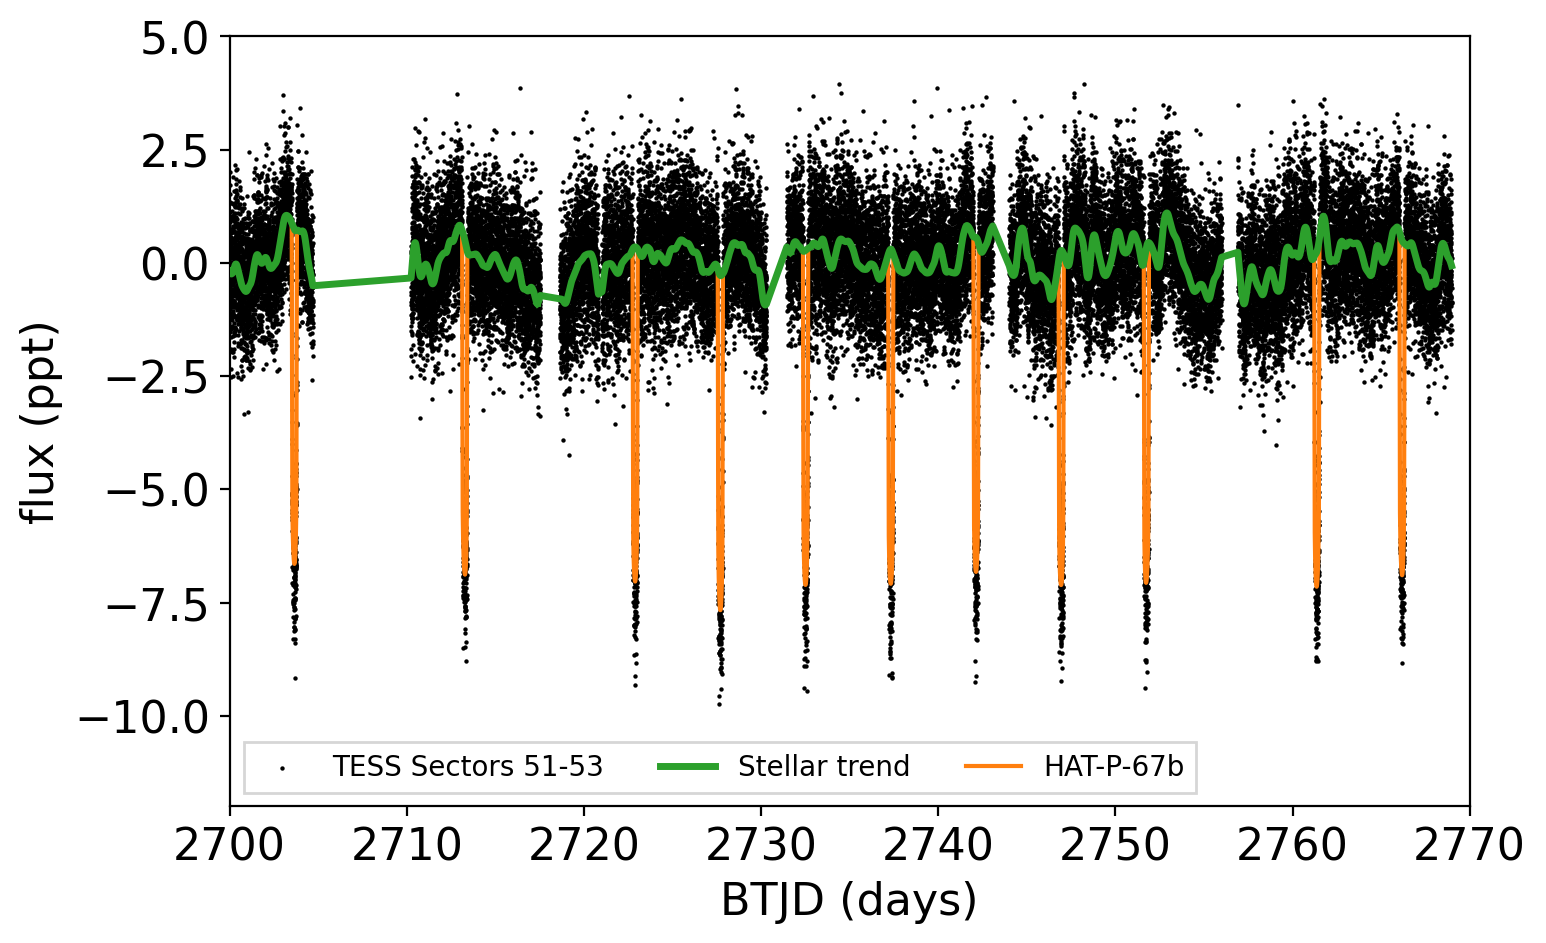

In [23]:
mask = np.ones(len(x), dtype=bool)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))


if len(x[mask]) > int(2e4):
    # see https://github.com/matplotlib/matplotlib/issues/5907
    mpl.rcParams["agg.path.chunksize"] = 10000

ax.scatter(
    x[mask],
    y[mask]*1000,
    c="k",
    s=2.5,
    rasterized=True,
    label="TESS Sectors 51-53",
    linewidths=0,
    zorder=42,
)
gp_mod = (soln["gp_pred"] + soln["mean"])
gp_mod_plus = (soln["gp_pred"] + soln["mean"])+(soln["transit_pred"][:, 0])
ax.plot(
    x[mask], gp_mod*1000, color="C2", label="Stellar trend", zorder=43, lw=2.5
)
ax.plot(
    x[mask], gp_mod_plus*1000, color="C1", label="HAT-P-67b", zorder=42, lw=1.5
)
ax.legend(fontsize=10, ncol=3, facecolor='w', fancybox=False)
ax.set_ylabel("flux (ppt)")
ax.set_xlim(2700, 2770)
ax.set_ylim(-12, 5)
ax.set_xlabel("BTJD (days)")
plt.savefig('../../paper/paper1/figures/TESS_S51_trend.png', dpi=300, bbox_inches='tight')

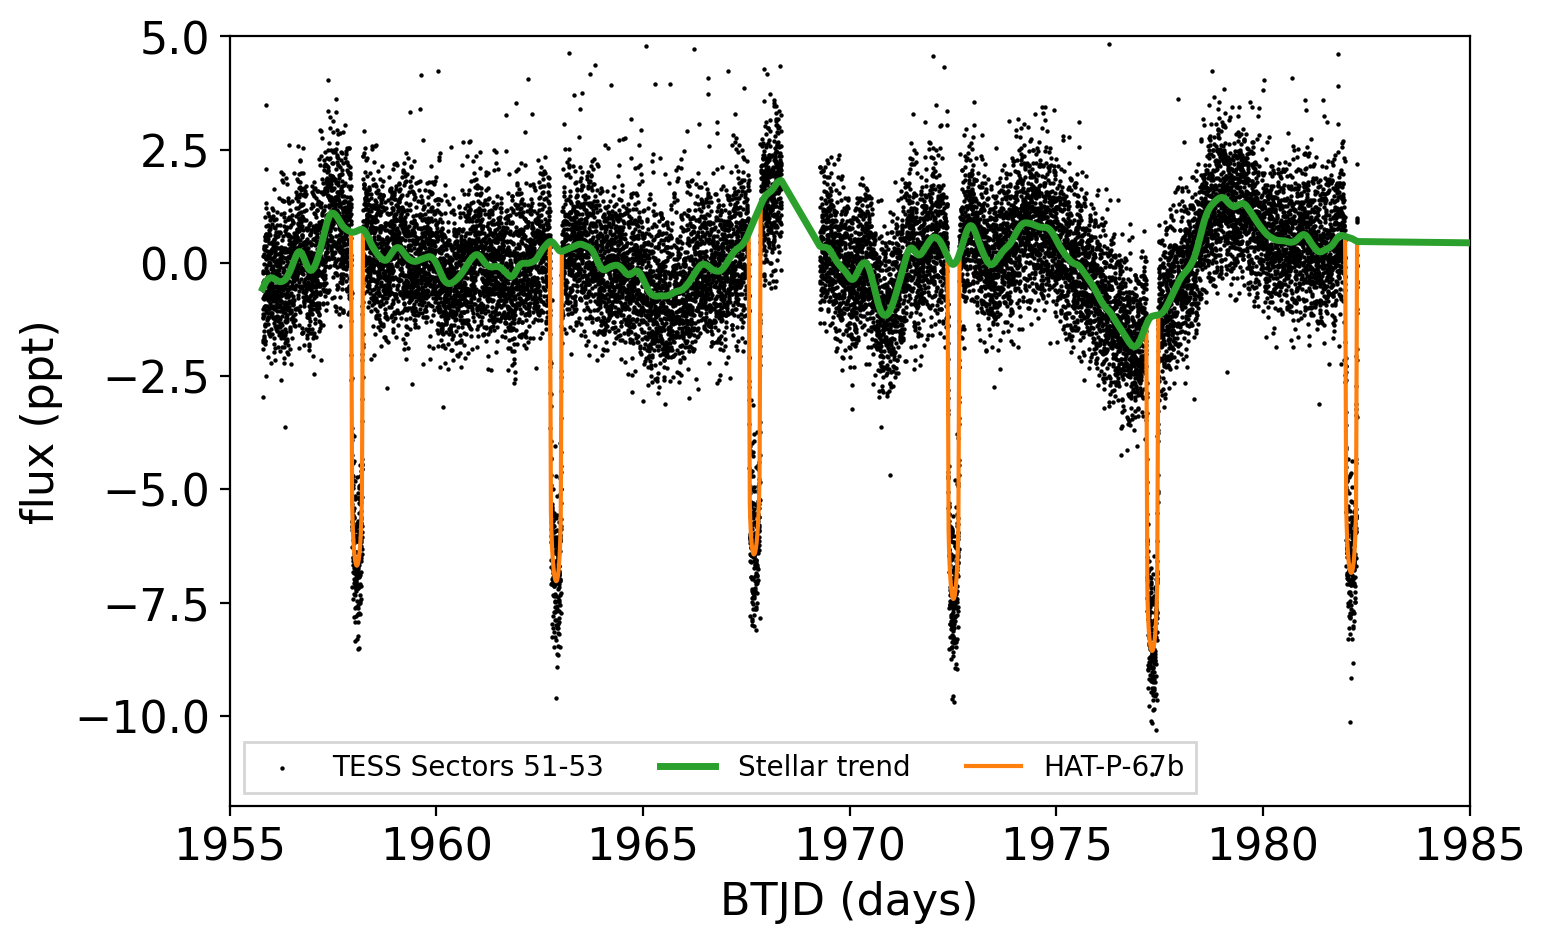

In [24]:
mask = np.ones(len(x), dtype=bool)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))


if len(x[mask]) > int(2e4):
    # see https://github.com/matplotlib/matplotlib/issues/5907
    mpl.rcParams["agg.path.chunksize"] = 10000

ax.scatter(
    x[mask],
    y[mask]*1000,
    c="k",
    s=2.5,
    rasterized=True,
    label="TESS Sectors 51-53",
    linewidths=0,
    zorder=42,
)
gp_mod = (soln["gp_pred"] + soln["mean"])
gp_mod_plus = (soln["gp_pred"] + soln["mean"])+(soln["transit_pred"][:, 0])
ax.plot(
    x[mask], gp_mod*1000, color="C2", label="Stellar trend", zorder=43, lw=2.5
)
ax.plot(
    x[mask], gp_mod_plus*1000, color="C1", label="HAT-P-67b", zorder=42, lw=1.5
)
ax.legend(fontsize=10, ncol=3, facecolor='w', fancybox=False)
ax.set_ylabel("flux (ppt)")
ax.set_xlim(1955, 1985)
ax.set_ylim(-12, 5)
ax.set_xlabel("BTJD (days)")
plt.savefig('../../paper/paper1/figures/TESS_S24_trend.png', dpi=300, bbox_inches='tight')

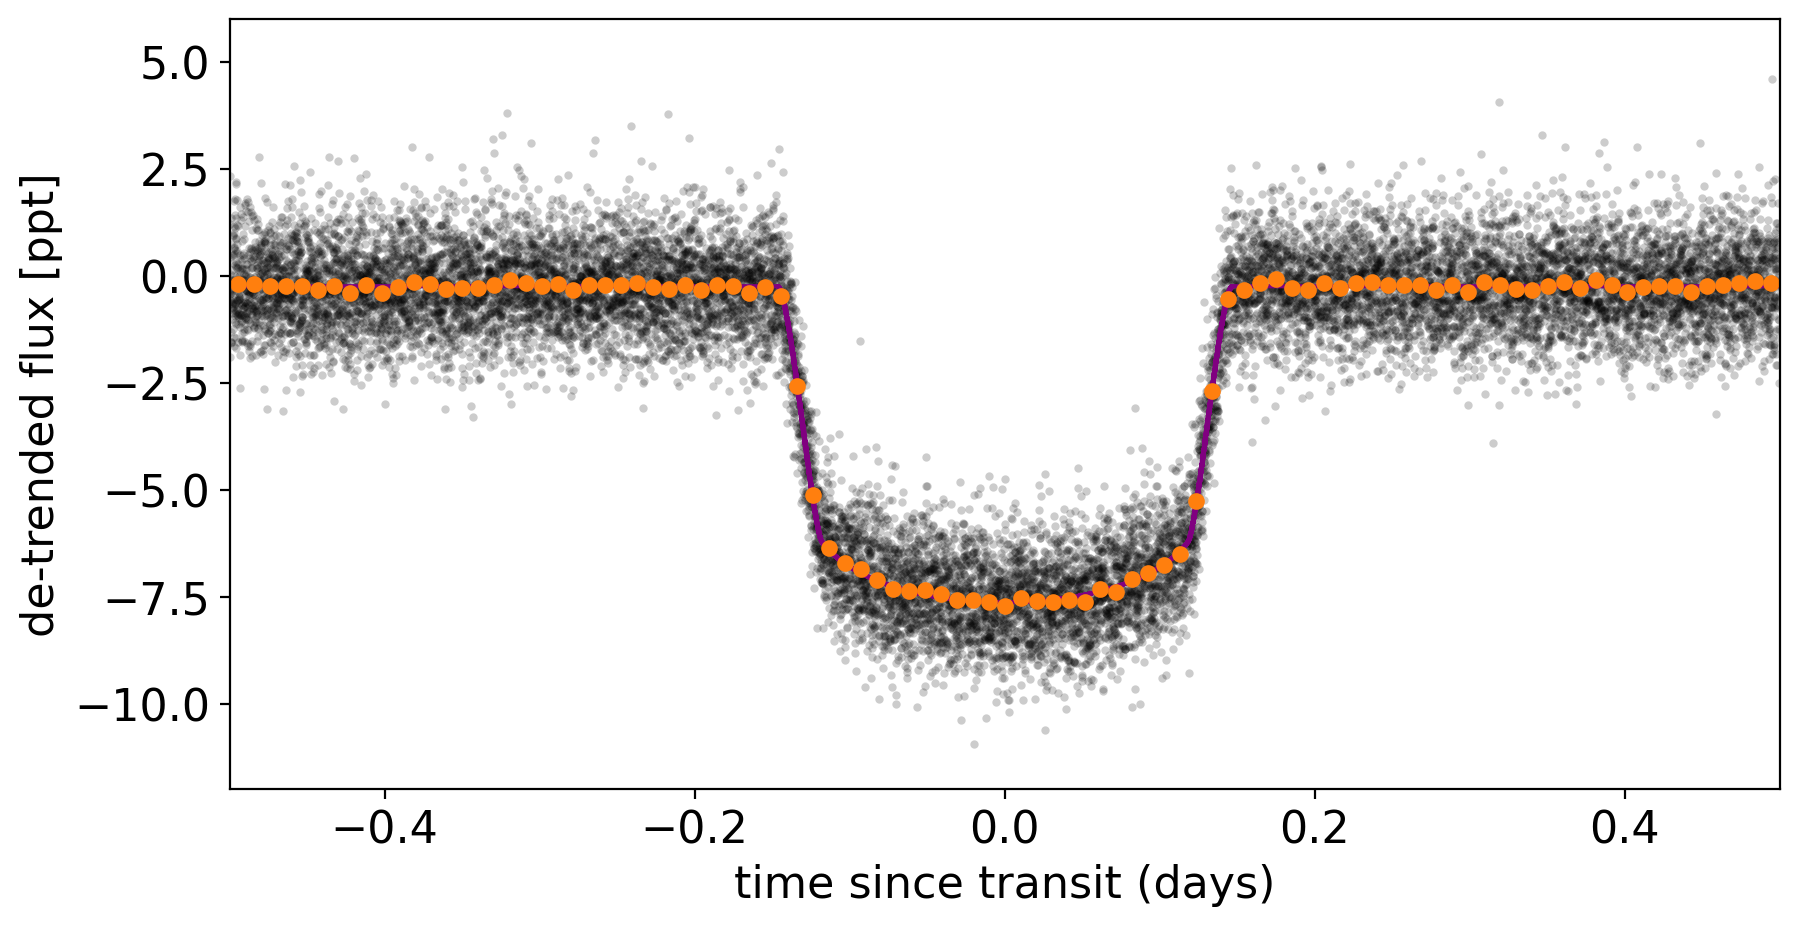

In [25]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))

t0 = T0_BTJD
period = 4.8101046

x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (y[m] - map_estimate["gp_pred"][m]),
    c="k",
    marker=".",
    alpha=0.2,
    linewidths=0,
)

lc_mod = map_estimate["transit_pred"][:, 0]
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody + map_estimate["mean"]), c="purple", zorder=1)

# Overplot the phase binned light curve
bins = np.linspace(-0.51, 0.51, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y - map_estimate["gp_pred"])
denom[num == 0] = 1.0
ax.scatter(
    0.5 * (bins[1:] + bins[:-1]),
    1e3 * num / denom,
    color="C1",
    zorder=2,
    linewidths=0,
)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-12, 6)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit (days)")

plt.savefig('../../paper/paper1/figures/best_fit_orbit.png', 
           bbox_inches='tight', dpi=300)

In [26]:
vals = (1e3 * (lc_mody)) < -0.0000000000001

In [27]:
0.0019 * 24

0.0456

In [28]:
(np.max(lc_modx[vals]) - np.min(lc_modx[vals])) * 24

7.067503742797378

Yay! Nice figure!  Let's look at the best fit values.

In [29]:
map_estimate['ecc']

array(0.19480244)

In [30]:
map_estimate

{'mean': array(-0.00023624),
 'logg_star': array(3.85400273),
 'r_star': array(2.54483437),
 'u_star_quadlimbdark__': array([-1.72481642, -0.48120474]),
 'b_interval__': array(-0.17556261),
 'log_depth': array(-4.90712904),
 't0': array(1958.0793463),
 'period': array(4.8101098),
 'ecs_unitdisk+interval__': array([-0.81473246, -0.4716986 ]),
 'log_jitter': array(-11.3019474),
 'sigma_rot_log__': array(-0.01153194),
 'log_prot': array(3.09300007),
 'log_Q0': array(8.96525459),
 'log_dQ': array(0.00097334),
 'f_interval__': array(1.31866429),
 'rho_star': array(0.14435811),
 'u_star': array([0.29710292, 0.09180815]),
 'b': array(0.45622174),
 'depth': array(0.00739368),
 'ror': array(0.08232644),
 'r_pl': array(0.20950715),
 'ecs': array([-0.38623409, -0.21360167]),
 'ecc': array(0.19480244),
 'omega': array(-2.63642091),
 'transit_pred': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'sigma_rot': array(0.9885343),
 'prot': array(22.043

In [31]:
params = (
    "mean,logg_star,r_star,period,t0,log_depth,b,log_jitter,log_prot"
    ",log_Q0,log_dQ,rho_star,depth,ror,sigma_rot,prot,f,r_planet".split(
        ","
    )
)
for p in params:
    print(f"{p}: {map_estimate[p]:.5f}")

mean: -0.00024
logg_star: 3.85400
r_star: 2.54483
period: 4.81011
t0: 1958.07935
log_depth: -4.90713
b: 0.45622
log_jitter: -11.30195
log_prot: 3.09300
log_Q0: 8.96525
log_dQ: 0.00097
rho_star: 0.14436
depth: 0.00739
ror: 0.08233
sigma_rot: 0.98853
prot: 22.04311
f: 0.79107
r_planet: 2.03875


Things look about right.  The planet is about $2.15 R_{jup}$, on a close-in orbit.  It's worth noting that the MAP value of $f$, the mixing fraction between the two frequencies in the `RotationTerm` kernel, favors a value so low to the bottom of our prior.   Also, we should check whether our jitter makes sense:

In [32]:
print(f"jitter is {np.exp(map_estimate['log_jitter'])*1e3:.4f} ppt")
print(f"mean(yerr) is {np.mean(yerr)*1e3:.2f} ppt")

jitter is 0.0123 ppt
mean(yerr) is 0.99 ppt


# Sampling

Finally, we can of course go on to sample.  This takes a few hours to convergence on a typical MacBook, and so to keep this notebook from requiring lots of resources, by default we won't do it.

In [33]:
import platform
import arviz as az

Let's MCMC Sample!

In [34]:
# Change this to "1" if you wish to run it.
RUN_THE_SAMPLING = 0

if RUN_THE_SAMPLING:

    with model:
        trace = pm.sample(
            tune=1500,
            draws=1000,
            start=map_estimate,
            # Parallel sampling runs poorly or crashes on macos
            cores=1,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
            random_seed=[261136679, 261136680],
            init="adapt_full",
        )

    az.summary(
        trace,
        var_names=[
            "mean",
            "logg_star",
            "r_star",
            "t0",
            "period",
            "b",
            "u_star",
            "log_depth",
            "depth",
            "ecc",
            "omega",
            "log_jitter",
            "sigma_rot",
            "log_prot",
            "log_Q0",
            "log_dQ",
            "f",
            "r_planet",
        ],
    )